# ADR Regression With CatBoost

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import sys
import os
sys.path.append(os.path.abspath(".."))

c:\Users\Sebastijan\anaconda3\envs\hotel_management\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Import

In [2]:
data = pd.read_parquet("../../data/hotel_booking_optimized.parquet")
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


## Preparing the Data

In [3]:
# A function to map week number to season
def week_to_season(week):
    if 10 <= week <= 21:
        return 'Spring'
    elif 22 <= week <= 34:
        return 'Summer'
    elif 35 <= week <= 47:
        return 'Fall'
    else:
        return 'Winter'

data["total_stay"] = data["stays_in_weekend_nights"] + data["stays_in_week_nights"]
data["arrival_season"] = data["arrival_date_week_number"].apply(week_to_season)

In [4]:
numeric_features = [
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults', 'children', 'babies',
    'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'total_stay'
]

categorical_features = [
    'hotel',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'deposit_type',
    'agent',
    'customer_type',
    'arrival_season'
]


In [5]:
for col in categorical_features:
    data[col] = data[col].astype(str).fillna('missing')

## Train/Test Split

In [6]:
X = data[numeric_features + categorical_features].copy()
y = data["adr"].copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42
)  # 0.15 x 0.8 = 0.12   

## First Model

### Preparation

In [7]:
class SklearnCatBoost(CatBoostRegressor, BaseEstimator):
    pass

cb = SklearnCatBoost(
    loss_function="RMSE", 
    verbose=100, 
    random_seed=42,
    task_type="GPU",
    devices='0'
)

In [8]:
param_dist_1 = {
    'iterations': [500, 1000, 1500, 2000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.3, 0.7, 1],
    'random_strength': [0, 1, 3, 5, 10]
}

In [9]:
fit_params = {
    'cat_features': categorical_features,
    'eval_set': (X_val, y_val),
    'early_stopping_rounds': 100
}

In [10]:
random_search_1 = RandomizedSearchCV(
    estimator=cb,
    param_distributions=param_dist_1,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1
)

### Search

In [11]:
random_search_1.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
0:	learn: 51.5271271	test: 45.4812428	best: 45.4812428 (0)	total: 37.6ms	remaining: 18.8s
100:	learn: 32.6568293	test: 22.9118968	best: 22.9118968 (100)	total: 1.35s	remaining: 5.35s
200:	learn: 31.5338130	test: 21.8071492	best: 21.7979340 (198)	total: 2.67s	remaining: 3.98s
300:	learn: 31.0133356	test: 21.1897675	best: 21.1897675 (300)	total: 4.02s	remaining: 2.66s
400:	learn: 30.5997887	test: 20.8687981	best: 20.8687981 (400)	total: 5.39s	remaining: 1.33s
499:	learn: 30.0211706	test: 20.6675829	best: 20.6675829 (499)	total: 6.74s	remaining: 0us
bestTest = 20.66758294
bestIteration = 499
[CV] END bagging_temperature=1, depth=4, iterations=500, l2_leaf_reg=3, learning_rate=0.1, random_strength=0; total time=   7.6s
0:	learn: 51.5649160	test: 45.4551737	best: 45.4551737 (0)	total: 12.5ms	remaining: 6.24s
100:	learn: 31.9120479	test: 23.0819822	best: 23.0819822 (100)	total: 1.31s	remaining: 5.18s
200:	learn: 30.5596911	test: 21

,estimator,"SklearnCatBoo..., verbose=100)"
,param_distributions,"{'bagging_temperature': [0, 0.3, ...], 'depth': [4, 6, ...], 'iterations': [500, 1000, ...], 'l2_leaf_reg': [1, 3, ...], ...}"
,n_iter,20
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [12]:
random_search_1.best_params_

{'random_strength': 10,
 'learning_rate': 0.05,
 'l2_leaf_reg': 1,
 'iterations': 2000,
 'depth': 8,
 'bagging_temperature': 0}

In [13]:
random_search_1.best_estimator_

,iterations,2000
,learning_rate,0.05
,depth,8
,l2_leaf_reg,1
,loss_function,'RMSE'
,random_seed,42
,verbose,100
,random_strength,10
,bagging_temperature,0
,task_type,'GPU'
,devices,'0'


- Note: retraining because the kernel broke before evaluation was done

### Retrain

In [11]:
cat_boost_1 = CatBoostRegressor(
    loss_function="RMSE", 
    verbose=100,
    random_seed=42,
    task_type="GPU",
    devices='0',

    # hyperparameters from RandomizedSearchCV best params
    random_strength=10,
    learning_rate=0.05,
    l2_leaf_reg=1,
    iterations=2000,
    depth=8,
    bagging_temperature=0
)

In [12]:
cat_boost_1.fit(
    X_train,
    y_train,
    cat_features=categorical_features,
    eval_set=(X_val, y_val),
    early_stopping_rounds=100,
    use_best_model=True # not needed, but explicitly states the intention
)

0:	learn: 50.4505948	test: 46.2252520	best: 46.2252520 (0)	total: 177ms	remaining: 5m 53s
100:	learn: 27.0586561	test: 22.4190493	best: 22.4190493 (100)	total: 2.99s	remaining: 56.2s
200:	learn: 23.7258424	test: 20.7241957	best: 20.7241957 (200)	total: 5.79s	remaining: 51.8s
300:	learn: 21.6400925	test: 19.9009772	best: 19.9009772 (300)	total: 8.62s	remaining: 48.6s
400:	learn: 20.5742081	test: 19.3845470	best: 19.3845470 (400)	total: 11.4s	remaining: 45.6s
500:	learn: 19.6116589	test: 19.0954244	best: 19.0884709 (499)	total: 14.1s	remaining: 42.3s
600:	learn: 19.0201055	test: 18.8487911	best: 18.8487911 (600)	total: 16.9s	remaining: 39.4s
700:	learn: 18.4226148	test: 18.5704475	best: 18.5704475 (700)	total: 19.7s	remaining: 36.5s
800:	learn: 18.0221630	test: 18.4109129	best: 18.4109129 (800)	total: 22.5s	remaining: 33.7s
900:	learn: 17.6101998	test: 18.2646910	best: 18.2646910 (900)	total: 25.4s	remaining: 31s
1000:	learn: 17.2793290	test: 18.1362771	best: 18.1362771 (1000)	total: 28.

### Evaluation

In [13]:
y_pred = cat_boost_1.predict(X_test)

In [14]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("First model evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.3f}")

First model evaluation:
RMSE: 17.91
MAE:  11.03
R²:   0.861


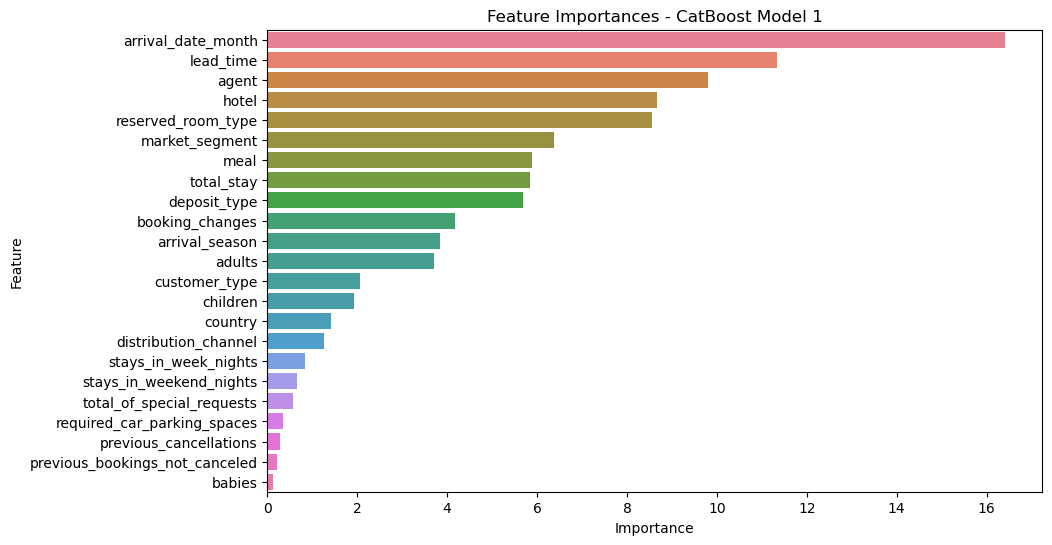

In [17]:
feature_importances_1 = cat_boost_1.get_feature_importance()
feature_names = X_train.columns

df_imp_1 = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_1
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp_1, hue="Feature", legend=False)
plt.title("Feature Importances - CatBoost Model 1")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show();

In [18]:
df_imp_1

,Feature,Importance
13,arrival_date_month,16.420050
0,lead_time,11.347736
20,agent,9.797001
12,hotel,8.662110
18,reserved_room_type,8.549091
16,market_segment,6.371548
14,meal,5.890593
11,total_stay,5.845685
19,deposit_type,5.694703
8,booking_changes,4.163635


## Second Model

In [19]:
param_dist_2 = {
    'iterations': [1800, 2000, 2200, 2500],
    'depth': [7, 8, 9],
    'learning_rate': [0.04, 0.05, 0.06, 0.07],
    'l2_leaf_reg': [0.5, 1, 2],
    'bagging_temperature': [0, 0.1],
    'random_strength': [8, 10, 12, 15]
}

In [20]:
fit_params_2 = {
    'cat_features': categorical_features,
    'eval_set': (X_val, y_val),
    'early_stopping_rounds': 100,
    "use_best_model": True # not needed, but explicitly states the intention
}

In [21]:
random_search_2 = RandomizedSearchCV(
    estimator=cb,
    param_distributions=param_dist_2,
    n_iter=40,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1
)

In [22]:
random_search_2.fit(X_train, y_train, **fit_params_2)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
0:	learn: 51.9162270	test: 45.8401254	best: 45.8401254 (0)	total: 16.5ms	remaining: 33s
100:	learn: 29.8627671	test: 22.2632304	best: 22.2632304 (100)	total: 2.33s	remaining: 43.8s
200:	learn: 26.4546427	test: 20.7912419	best: 20.7912419 (200)	total: 4.71s	remaining: 42.1s
300:	learn: 25.2485988	test: 20.0734691	best: 20.0734691 (300)	total: 7.13s	remaining: 40.3s
400:	learn: 23.8039995	test: 19.7010382	best: 19.7010382 (400)	total: 9.49s	remaining: 37.8s
500:	learn: 22.7450958	test: 19.4051079	best: 19.4051079 (500)	total: 11.8s	remaining: 35.4s
600:	learn: 22.3076324	test: 19.1912136	best: 19.1912136 (600)	total: 14.1s	remaining: 32.9s
700:	learn: 21.9196102	test: 19.0232048	best: 19.0053976 (693)	total: 16.5s	remaining: 30.5s
800:	learn: 21.5563497	test: 18.8857004	best: 18.8857004 (800)	total: 18.8s	remaining: 28.2s
900:	learn: 20.8579018	test: 18.7791215	best: 18.7791215 (900)	total: 21.1s	remaining: 25.8s
1000:	learn: 

,estimator,"SklearnCatBoo..., verbose=100)"
,param_distributions,"{'bagging_temperature': [0, 0.1], 'depth': [7, 8, ...], 'iterations': [1800, 2000, ...], 'l2_leaf_reg': [0.5, 1, ...], ...}"
,n_iter,40
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [23]:
random_search_2.best_params_

{'random_strength': 10,
 'learning_rate': 0.05,
 'l2_leaf_reg': 0.5,
 'iterations': 2500,
 'depth': 9,
 'bagging_temperature': 0}

In [25]:
cat_boost_2 = random_search_2.best_estimator_
cat_boost_2

,iterations,2500
,learning_rate,0.05
,depth,9
,l2_leaf_reg,0.5
,loss_function,'RMSE'
,random_seed,42
,verbose,100
,random_strength,10
,bagging_temperature,0
,task_type,'GPU'
,devices,'0'


### Evaluation

In [26]:
y_pred_2 = cat_boost_2.predict(X_test)

In [27]:
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))
mae_2 = mean_absolute_error(y_test, y_pred_2)
r2_2 = r2_score(y_test, y_pred_2)

print("Second model evaluation:")
print(f"RMSE: {rmse_2:.2f}")
print(f"MAE:  {mae_2:.2f}")
print(f"R²:   {r2_2:.3f}")

Second model evaluation:
RMSE: 17.36
MAE:  10.51
R²:   0.870


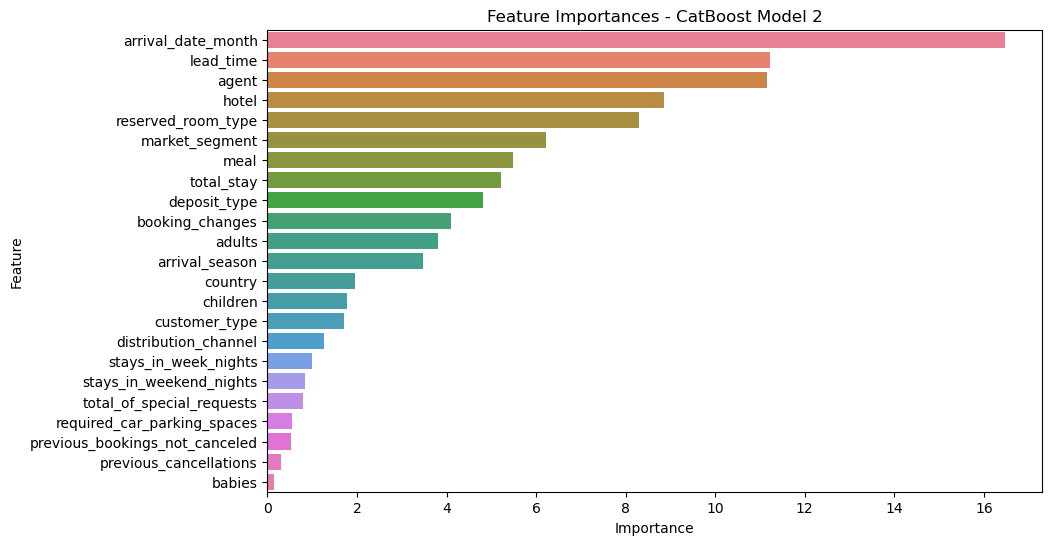

In [28]:
feature_importances_2 = cat_boost_2.get_feature_importance()
feature_names = X_train.columns

df_imp_2 = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_2
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp_2, hue="Feature", legend=False)
plt.title("Feature Importances - CatBoost Model 2")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show();

## Final Model

### Retraining with train and val

In [15]:
final_model = CatBoostRegressor(
    loss_function="RMSE", 
    verbose=100,
    random_seed=42,
    task_type="CPU", # changed to CPU for broader compatibility

    # hyperparameters from RandomizedSearchCV best params
    random_strength=10,
    learning_rate=0.05,
    l2_leaf_reg=0.5,
    iterations=2500,
    depth=9,
    bagging_temperature=0
)

In [16]:
final_model.fit(
    X_train_val,
    y_train_val,
    cat_features=categorical_features,
    early_stopping_rounds=100
)

0:	learn: 50.0287264	total: 63.6ms	remaining: 2m 38s
100:	learn: 28.0123832	total: 6.06s	remaining: 2m 23s
200:	learn: 24.9943518	total: 11.5s	remaining: 2m 11s
300:	learn: 22.6737956	total: 17.7s	remaining: 2m 9s
400:	learn: 20.5227092	total: 24.3s	remaining: 2m 7s
500:	learn: 19.2808417	total: 31.1s	remaining: 2m 4s
600:	learn: 18.4565644	total: 37.7s	remaining: 1m 59s
700:	learn: 17.7072509	total: 44.2s	remaining: 1m 53s
800:	learn: 17.2280997	total: 50.8s	remaining: 1m 47s
900:	learn: 16.9018419	total: 57.2s	remaining: 1m 41s
1000:	learn: 16.5606357	total: 1m 3s	remaining: 1m 35s
1100:	learn: 16.2499292	total: 1m 10s	remaining: 1m 29s
1200:	learn: 16.0343554	total: 1m 17s	remaining: 1m 23s
1300:	learn: 15.8245296	total: 1m 23s	remaining: 1m 17s
1400:	learn: 15.6209069	total: 1m 30s	remaining: 1m 10s
1500:	learn: 15.3901078	total: 1m 37s	remaining: 1m 4s
1600:	learn: 15.1962207	total: 1m 43s	remaining: 58.2s
1700:	learn: 15.0204933	total: 1m 50s	remaining: 51.8s
1800:	learn: 14.8731

### Preparing the final model for saving

In [17]:
required_columns = numeric_features + categorical_features

required_columns = [c for c in required_columns if c not in ['arrival_season', 'total_stay']]

In [18]:
# A predictor class that includes feature engineering
# Model inside, since we need feature engineering to be consistent
class ADRPredictor:
    def __init__(self, model, categorical_features, required_columns):
        self.model = model
        self.categorical_features = categorical_features
        self.required_columns = required_columns

    def week_to_season(self, week):
        if 10 <= week <= 21:
            return 'Spring'
        elif 22 <= week <= 34:
            return 'Summer'
        elif 35 <= week <= 47:
            return 'Fall'
        else:
            return 'Winter'

    def validate_schema(self, X):
        missing = [c for c in self.required_columns if c not in X.columns]
        if missing:
            raise ValueError(
                f"Model input schema violation. Missing columns: {missing}"
            )
        return X

    def _engineer_features(self, X):
        X = X.copy()
        X["total_stay"] = X["stays_in_weekend_nights"] + X["stays_in_week_nights"]
        X["arrival_season"] = X["arrival_date_week_number"].apply(self.week_to_season)
        for col in self.categorical_features:
            X[col] = X[col].astype(str).fillna('missing')
        return X

    def predict(self, X):
        X = self.validate_schema(X)
        X = self._engineer_features(X)
        X_processed = X[self.required_columns + ["total_stay", "arrival_season"]].copy()
        return self.model.predict(X_processed)

In [19]:
adr_predictor = ADRPredictor(
    model=final_model, 
    categorical_features=categorical_features, 
    required_columns=required_columns
)

### Evaluating the final model

In [20]:
y_pred_final = final_model.predict(X_test)

In [21]:
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("Final model evaluation:")
print(f"RMSE: {rmse_final:.2f}")
print(f"MAE:  {mae_final:.2f}")
print(f"R²:   {r2_final:.3f}")

Final model evaluation:
RMSE: 17.32
MAE:  10.49
R²:   0.870


### Saving the final model

In [22]:
joblib.dump(adr_predictor, "../../models/adr_regression_predictor.joblib", compress=("lz4", 3))

['../../models/adr_regression_predictor.joblib']

### Checking the feature importances

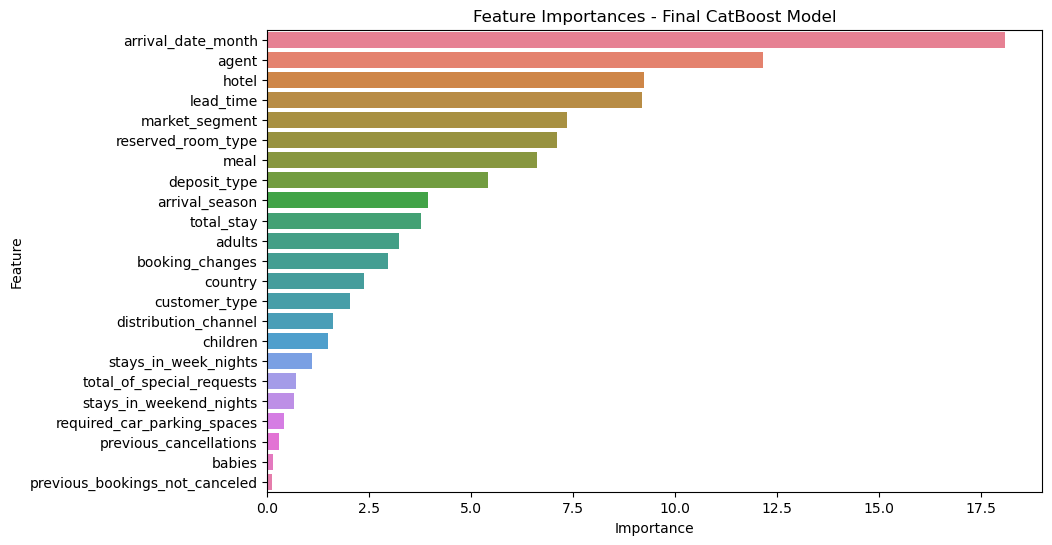

In [23]:
feature_importances_final = final_model.get_feature_importance()
feature_names_final = X_train.columns

df_imp_final = pd.DataFrame({
    'Feature': feature_names_final,
    'Importance': feature_importances_final
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp_final, hue="Feature", legend=False)
plt.title("Feature Importances - Final CatBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show();

### Saving the feature importances

### Top 20

In [25]:
top_20_feature_importances = df_imp_final[:20]
top_20_feature_importances.to_csv("../../models/adr_regression_feature_importances.csv", index=False)

### Saving the shap values

In [26]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

In [27]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': mean_abs_shap
}).sort_values(by='SHAP_Importance', ascending=False)

shap_importance

,Feature,SHAP_Importance
13,arrival_date_month,11.611603
18,reserved_room_type,7.394317
20,agent,7.065901
12,hotel,6.464458
0,lead_time,4.940825
16,market_segment,4.813460
14,meal,4.609449
22,arrival_season,2.494021
3,adults,2.354979
19,deposit_type,2.285948


#### Top 20

In [28]:
top_20_shap_importances = shap_importance[:20]
top_20_shap_importances.to_csv("../../models/adr_regression_shap_importances.csv", index=False)

## END OF FILE